In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directxory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/batches.meta
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/readme.html


In [2]:
import torch
from torch.utils.data import Dataset
import numpy as np
from PIL import Image

class CIFARDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):

        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]

        # 1) If shape is (3072,) => reshape to (3,32,32)
        if x.shape[0] == 3072 and x.ndim == 1:
            x = x.reshape(3, 32, 32)

        # 2) If shape is (32,32,3) => transpose to (3,32,32)
        elif x.shape == (32, 32, 3):
            x = np.transpose(x, (2, 0, 1))

        # Convert to a PIL image for torchvision transforms
        # x is [3, H, W], so we convert to [H, W, 3] first
        x = np.transpose(x, (1, 2, 0))  # shape => (32, 32, 3)
        img = Image.fromarray(x.astype(np.uint8))

        # Apply transforms if given
        if self.transform:
            img = self.transform(img)

        # Return (img, label) if labels exist, else just img
        if self.labels is not None:
            label = self.labels[idx]
            return img, label
        else:
            return img


In [4]:
import pickle
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.transforms import AutoAugmentPolicy

# Basic transforms for baseline (will upgrade these later)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(AutoAugmentPolicy.CIFAR10),  # Automated augmentation policy
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465],
                         [0.2023, 0.1994, 0.2010]),

    transforms.RandomErasing(p=0.5),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4942, 0.4851, 0.4504], std=[0.2020, 0.1991, 0.2011]),
])

# Define batch file paths
train_files = [
    '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1',
    '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_2',
    '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_3',
    '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_4',
    '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_5'
]
test_file = '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch'

all_data = []
all_labels = []
for a in train_files:
    with open(a, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    all_data.append(batch[b'data'])      # shape => (10000, 3072) each
    all_labels.extend(batch[b'labels'])  # 10000 labels

# Concatenate into a single NumPy array
train_data = np.vstack(all_data)          # (50000, 3072)
train_labels = np.array(all_labels)       # (50000,)

# Train dataset
train_dataset = CIFARDataset(data=train_data,
                             labels=train_labels,
                             transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

with open(test_file, 'rb') as f:
    batch = pickle.load(f, encoding='bytes')
test_data = np.array(batch[b'data'])   # (10000, 3072)
test_labels = np.array(batch[b'labels'])

test_dataset = CIFARDataset(data=test_data,
                            labels=test_labels,
                            transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1. Define a 1x1 convolution helper (as used in Model 1)
def conv1x1(in_channels, out_channels, stride=1, groups=1, bias=False):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, groups=groups, bias=bias)

# 2. Convolution-based SE Block (using 1x1 convolutions)
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=8):
        super(SEBlock, self).__init__()
        mid_channels = channels // reduction
        self.pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv1 = conv1x1(in_channels=channels, out_channels=mid_channels, bias=True)
        self.activ = nn.ReLU(inplace=True)
        self.conv2 = conv1x1(in_channels=mid_channels, out_channels=channels, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        w = self.pool(x)
        w = self.conv1(w)
        w = self.activ(w)
        w = self.conv2(w)
        w = self.sigmoid(w)
        return x * w

# 3. BasicBlock with SE (modified dropout and SE implementation)
class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, reduction=8, dropout_rate=0.0):
        super(SEBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)

        # Use the convolution-based SE Block
        self.se    = SEBlock(planes, reduction=reduction)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

        # Set dropout to Identity if dropout_rate is zero
        self.dropout = nn.Dropout(p=dropout_rate) if dropout_rate > 0.0 else nn.Identity()

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out = self.se(out)   # Apply Squeeze-and-Excitation
        out += self.shortcut(x)
        out = F.relu(out, inplace=True)
        return out

# 4. Modified SE-ResNet for CIFAR-10 with [4, 4, 4, 3] residual blocks
class SE_ResNet18Narrow(nn.Module):
    def __init__(self, num_classes=10, reduction=8):
        super(SE_ResNet18Narrow, self).__init__()
        self.in_planes = 32

        # Stem: from 3 channels to 64 channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(32)

        # Residual Layers with block counts [4, 4, 3]
        self.layer1 = self._make_layer(SEBasicBlock, 32, num_blocks=4, stride=1,
                                       reduction=reduction, dropout_rate=0.0)
        self.layer2 = self._make_layer(SEBasicBlock, 64, num_blocks=4, stride=1,
                                       reduction=reduction, dropout_rate=0.2)
        self.layer3 = self._make_layer(SEBasicBlock, 128, num_blocks=4, stride=2,
                                       reduction=reduction, dropout_rate=0.3)
        self.layer4 = self._make_layer(SEBasicBlock, 256, num_blocks=3, stride=2,
                                       reduction=reduction, dropout_rate=0.3)

        # Global average pooling and final classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, reduction, dropout_rate):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s, reduction=reduction, dropout_rate=dropout_rate))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

# 5. Factory function to instantiate the modified model for CIFAR-10
def SEResNet18Narrow_CIFAR10():
    return SE_ResNet18Narrow(num_classes=10, reduction=8)


In [6]:
!pip uninstall -y torch_xla  # Remove torch_xla if mistakenly installed
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121


In [7]:
import torch
import torch.cuda.amp as amp  # For mixed precision training on GPU

# Initialize GradScaler for automatic mixed precision (AMP)
scaler = amp.GradScaler()


<ipython-input-7-49e100a62159>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


In [8]:
!pip install torchsummary

In [9]:
!pip install torchinfo


In [10]:
from torchsummary import summary
from torchinfo import summary  # You can use one or the other

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Assume SEResNet18Narrow_CIFAR10 is already defined and imported
model = SEResNet18Narrow_CIFAR10().to(device)

# Create a CPU copy of the model for summary
model_cpu = SEResNet18Narrow_CIFAR10()
model_cpu.load_state_dict(model.state_dict())
model_cpu = model_cpu.cpu()

# Now call summary on model_cpu with the correct input size
summary(model_cpu, input_size=(1, 3, 32, 32))


Using device: cuda


Layer (type:depth-idx)                        Output Shape              Param #
SE_ResNet18Narrow                             [1, 10]                   --
├─Conv2d: 1-1                                 [1, 32, 32, 32]           864
├─BatchNorm2d: 1-2                            [1, 32, 32, 32]           64
├─Sequential: 1-3                             [1, 32, 32, 32]           --
│    └─SEBasicBlock: 2-1                      [1, 32, 32, 32]           --
│    │    └─Conv2d: 3-1                       [1, 32, 32, 32]           9,216
│    │    └─BatchNorm2d: 3-2                  [1, 32, 32, 32]           64
│    │    └─Identity: 3-3                     [1, 32, 32, 32]           --
│    │    └─Conv2d: 3-4                       [1, 32, 32, 32]           9,216
│    │    └─BatchNorm2d: 3-5                  [1, 32, 32, 32]           64
│    │    └─SEBlock: 3-6                      [1, 32, 32, 32]           292
│    │    └─Sequential: 3-7                   [1, 32, 32, 32]           --
│    └─SEBas

In [11]:
!pip install torch_optimizer
!pip install torch_lr_finder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.4 MB/s eta 0:00:00


## LR finder

In [ ]:
import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch_lr_finder import LRFinder

# Set device to GPU if available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Assume SEResNet18Narrow_CIFAR10 is already defined and imported
model_lr = SEResNet18Narrow_CIFAR10().to(device)

# Use a very low starting learning rate
optimizer_lr = optim.SGD(model_lr.parameters(), lr=1e-7, momentum=0.9, weight_decay=5e-4)
criterion_lr = CrossEntropyLoss(label_smoothing=0.1)

# Instantiate the LR finder
lr_finder = LRFinder(model_lr, optimizer_lr, criterion_lr, device=device)

# Run the range test on your training DataLoader
# Adjust end_lr and num_iter based on your dataset
lr_finder.range_test(train_loader, end_lr=2, num_iter=50)

# Plot learning rate vs. loss
lr_finder.plot()  # Choose an LR where the loss starts decreasing steeply

# Reset model and optimizer to their initial state
lr_finder.reset()


In [13]:
import torch
import torch.optim as optim
import torch_optimizer as optim2
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler
from torch.nn import CrossEntropyLoss

#  Set device to use GPU (RTX) if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#  Assume SEResNet18Narrow_CIFAR10 is already defined and imported
model = SEResNet18Narrow_CIFAR10().to(device)

#  Use label smoothing for improved generalization
criterion = CrossEntropyLoss(label_smoothing=0.1)

#  Base optimizer: SGD with momentum and weight decay
base_optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

#  Lookahead optimizer for improved stability
optimizer = optim2.Lookahead(base_optimizer, k=5, alpha=0.5)

num_epochs = 175
steps_per_epoch = len(train_loader)

#  Scheduler: Cosine Annealing
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

#  Mixed Precision Scaler for AMP
scaler = GradScaler()

#  Containers for tracking progress
train_losses = []
test_losses = []
test_accuracies = []

best_accuracy = 0.0
patience = 10  # Early stopping patience
patience_counter = 0
min_delta = 0.01  # Minimum improvement threshold

#  Enable Mixup augmentation for regularization
use_mixup = True

def mixup_data(x, y, alpha=0.2):
    """Applies Mixup augmentation to a batch."""
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    index = torch.randperm(x.size(0)).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Computes the mixup loss."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

#  Training Loop
for epoch in range(1, num_epochs + 1):
    model.train()
    running_train_loss = 0.0

    for step, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        #  Apply Mixup if enabled
        if use_mixup:
            images, y_a, y_b, lam = mixup_data(images, labels, alpha=0.2)
        
        with autocast(enabled=True):
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam) if use_mixup else criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Gradient clipping

        #  Optimizer step and update
        scaler.step(optimizer)
        scaler.update()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    #  Evaluation on the test set
    model.eval()
    running_test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracy = 100.0 * correct / total
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch}/{num_epochs}] - "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}"
          f"Train Loss: {avg_train_loss:.4f} - "
          f"Test Loss: {avg_test_loss:.4f} - "
          f"Test Accuracy: {test_accuracy:.2f}%")

    scheduler.step()

    #  Early Stopping
    improvement = test_accuracy - best_accuracy
    if abs(improvement) > min_delta:
        best_accuracy = test_accuracy
        patience_counter = 0
        #  Save the best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.optimizer.state_dict(),  # Lookahead stores base_optimizer
            'train_losses': train_losses,
            'test_losses': test_losses,
            'test_accuracies': test_accuracies,
        }, 'new_model_cifar10.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered! No significant improvement for {patience} epochs.")
            break

print("✅ Model saved as 'new_model_cifar10.pth'")


Using device: cuda


<ipython-input-13-eb1f25819180>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-13-eb1f25819180>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Epoch [1/175] - LR: 0.100000Train Loss: 2.0242 - Test Loss: 1.5371 - Test Accuracy: 52.91%
Epoch [2/175] - LR: 0.099992Train Loss: 1.7712 - Test Loss: 1.4024 - Test Accuracy: 59.44%
Epoch [3/175] - LR: 0.099968Train Loss: 1.6663 - Test Loss: 1.3289 - Test Accuracy: 63.91%
Epoch [4/175] - LR: 0.099928Train Loss: 1.5818 - Test Loss: 1.4440 - Test Accuracy: 58.97%
Epoch [5/175] - LR: 0.099871Train Loss: 1.5536 - Test Loss: 1.2238 - Test Accuracy: 67.65%
Epoch [6/175] - LR: 0.099799Train Loss: 1.4938 - Test Loss: 1.1757 - Test Accuracy: 70.19%
Epoch [7/175] - LR: 0.099710Train Loss: 1.4522 - Test Loss: 1.0653 - Test Accuracy: 75.96%
Epoch [8/175] - LR: 0.099606Train Loss: 1.4388 - Test Loss: 1.0805 - Test Accuracy: 74.60%
Epoch [9/175] - LR: 0.099485Train Loss: 1.4168 - Test Loss: 1.0919 - Test Accuracy: 74.84%
Epoch [10/175] - LR: 0.099349Train Loss: 1.3905 - Test Loss: 1.4770 - Test Accuracy: 57.97%
Epoch [11/175] - LR: 0.099196Train Loss: 1.3634 - Test Loss: 0.9862 - Test Accuracy: 79.1

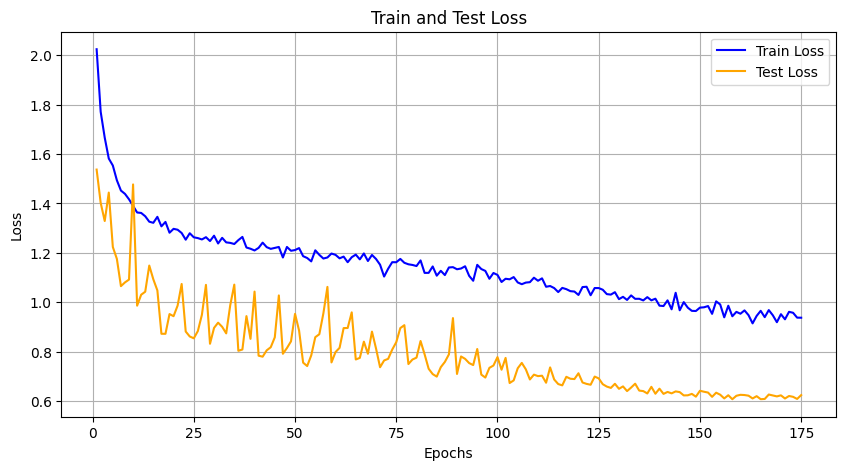

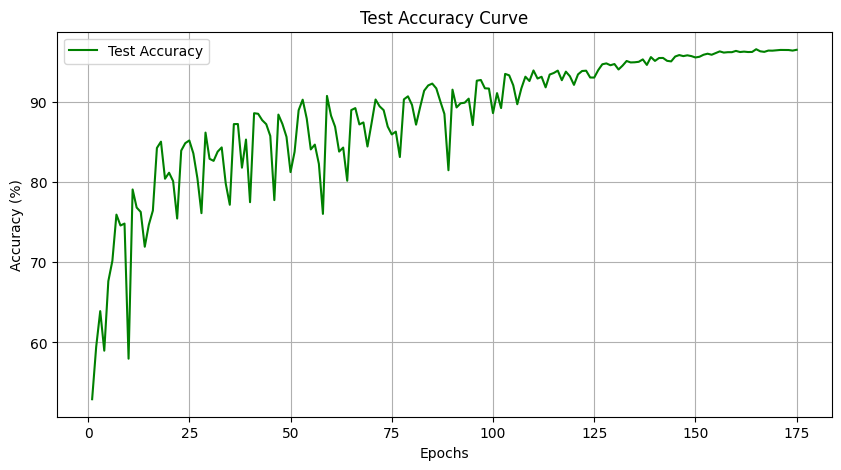

In [14]:
# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss", color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.grid()
plt.savefig('new_model_cifar10_loss_curve.png')
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve')
plt.legend()
plt.grid()
plt.savefig('new_model_cifar10_accuracy_curve.png')
plt.show()


## **Generate Test.csv**

In [16]:
kaggle_file = '/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl'
with open(kaggle_file, 'rb') as f:
    content = pickle.load(f, encoding='bytes')
kaggle_data = content[b'data']  # e.g. (10000, 32, 32, 3) or (10000, 3072)
kaggle_data = np.array(kaggle_data)

kaggle_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5121, 0.4964, 0.4612], std=[0.2115, 0.2103, 0.2119]),
])



kaggle_dataset = CIFARDataset(data=kaggle_data,
                              labels=None,   # no labels
                              transform=kaggle_test_transform)  # same as test transform
kaggle_loader = DataLoader(kaggle_dataset, batch_size=128, shuffle=False, num_workers=2)

In [17]:
import pandas as pd

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

all_predictions = []

with torch.no_grad():
    for images in kaggle_loader:
        images = images.to(device)
        preds = []
        
        # Original predictions
        outputs = model(images)
        preds.append(outputs)
        
        # TTA: Horizontal flip predictions
        outputs_flip = model(torch.flip(images, dims=[3]))
        preds.append(outputs_flip)
        
        # Average predictions across TTA variants
        avg_preds = torch.stack(preds).mean(dim=0)
        _, pred_labels = avg_preds.max(1)
        all_predictions.extend(pred_labels.cpu().numpy())


In [19]:
submission = pd.DataFrame({
    'ID': list(range(len(all_predictions))),
    'Labels': all_predictions
})

submission.to_csv('submission-12345.csv', index=False)